in this notebook we domonstrate how we simulate OAM beams and propagate them through phase screening.<br>
as we will go deeper in to research we will be able to better simulate the phase screening such that it will represent the actual turbulance in the channel.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import genlaguerre

def lg_beam(p, m, r, phi, z, w0, lam):
    zR = np.pi * w0**2 / lam
    wz = w0 * np.sqrt(1 + (z / zR)**2)
    Rz = z * (1 + (zR / z)**2)
    gouy = np.arctan(z / zR)
    k = 2 * np.pi / lam

    radial_term = (np.sqrt(2) * r / wz) ** abs(m)
    laguerre_term = genlaguerre(p, abs(m))(2 * r**2 / wz**2)
    amplitude = radial_term * laguerre_term * np.exp(-r**2 / wz**2)

    phase = np.exp(-1j * k * r**2 / (2 * Rz)) * np.exp(1j * (2 * p + abs(m) + 1) * gouy) * np.exp(-1j * m * phi)

    return amplitude * phase / wz


| Parameter | Meaning | Notes |
|-----------|---------|-------|
| **$p$** | Radial index | $p = 0, 1, 2, \dots$; number of radial nodes (intensity rings) |
| **$m$** | Azimuthal index (topological charge) | $m = \pm1, \pm2, \dots$; determines orbital angular momentum (OAM), phase twist $\exp(im\phi)$ |
| **$r$** | Radial coordinate | Distance from beam center (in transverse plane) |
| **$\phi$** | Azimuthal angle | Angle in the transverse plane |
| **$z$** | Propagation distance | Position along the optical axis |
| **$w_0$** | Beam waist | Radius at the narrowest point (z = 0) |
| **$w(z)$** | Beam radius at distance z | $w(z) = w_0 \sqrt{1 + (z/z_R)^2}$ |
| **$z_R$** | Rayleigh range | $z_R = \frac{\pi w_0^2}{\lambda}$; characterizes diffraction length |
| **$R(z)$** | Radius of wavefront curvature | $R(z) = z \left(1 + (z_R/z)^2\right)$ |
| **$\lambda$** | Wavelength | Usually in the near-infrared for FSO (e.g., 850 nm) |
| **$k$** | Wavenumber | $k = 2\pi/\lambda$ |
| **$L_p^{\|m\|}$** | Generalized Laguerre polynomial | Shapes the radial intensity profile |
| **Gouy phase** | $\zeta(z) = (2p + \|m\| + 1)\tan^{-1}(z/z_R)$ | Phase shift due to beam focusing |
| **$\exp(-im\phi)$** | Azimuthal phase | Imparts orbital angular momentum (helical phase) |

In [17]:
def generate_phase_screen(N, delta, Cn2, l0, L0, lam):
    # Spatial frequency grid
    fx = np.fft.fftfreq(N, delta)
    fy = np.fft.fftfreq(N, delta)
    FX, FY = np.meshgrid(fx, fy)
    kappa = 2 * np.pi * np.sqrt(FX**2 + FY**2)

    # Outer and inner scales
    k0 = 2 * np.pi / L0
    kl = 3.3 / l0

    # Kolmogorov spectrum
    Phi = 0.033 * Cn2 * np.exp(-kappa**2 / kl**2) / ((kappa**2 + k0**2) ** (11/6))
    Phi[kappa == 0] = 0  # avoid divide by zero

    # Generate random phase screen in frequency domain
    random_phase = np.random.normal(size=(N,N)) + 1j * np.random.normal(size=(N,N))
    FT_phase = random_phase * np.sqrt(Phi)

    # Transform to spatial domain
    phase_screen = np.fft.ifft2(np.fft.fftshift(FT_phase)).real
    return np.exp(1j * phase_screen) , phase_screen


this is a small resolution illustration of a phase screen wher the different intensities of the image are the different phase based on the distribution produced by the kolmogrov spectrum :
$$\Phi(\kappa) = 0.033C_n^2 \frac{\exp(-\kappa^2/\kappa_l^2)}{(\kappa^2 + \kappa_0^2)^{11/6}} f(\kappa, \kappa_l) $$
$$ f(\kappa, \kappa_l) = 1 + 1.802(\kappa/\kappa_l) - 0.254(\kappa/\kappa_l)^{7/6} $$

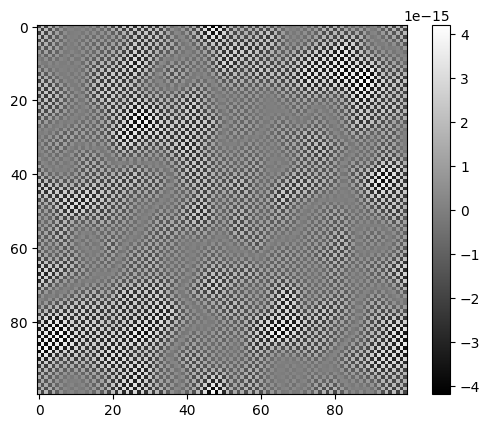

In [18]:
_,screen_example = generate_phase_screen(N=100, delta = 1.36e-3, Cn2=5e-15, l0=5e-3, L0 = 20, lam=850e-9)
plt.imshow(screen_example, cmap='gray')
plt.colorbar()
plt.show()

In [19]:
def propagate_beam(u0, dz, lam, delta, z_total, phase_screens):
    N = u0.shape[0]
    k = 2 * np.pi / lam

    fx = np.fft.fftfreq(N, delta)
    fy = np.fft.fftfreq(N, delta)
    FX, FY = np.meshgrid(fx, fy)
    H = np.exp(-1j * np.pi * lam * dz * (FX**2 + FY**2))  # transfer function

    u = u0.copy()
    for screen in phase_screens:
        u = u * screen
        U = np.fft.fft2(u)
        U = U * H
        u = np.fft.ifft2(U)

    return u


In [20]:
def simulate_oam_propagation(m=1, p=0, z=1000, steps=20, w0=0.016, lam=850e-9, Cn2=5e-15, l0=5e-3, L0=20,N = 512):
    N = 512
    delta = 1.36e-3
    dz = z / steps

    # Grid
    x = np.linspace(-N//2, N//2-1, N) * delta
    X, Y = np.meshgrid(x, x)
    r = np.sqrt(X**2 + Y**2)
    phi = np.arctan2(Y, X)

    # Initial beam
    u0 = lg_beam(p, m, r, phi, z, w0, lam)

    # Generate phase screens
    screens = [generate_phase_screen(N, delta, Cn2, l0, L0, lam)[0] for _ in range(steps)]

    # Propagate
    u_out = propagate_beam(u0, dz, lam, delta, z, screens)

    return np.abs(u_out)**2


In [21]:
results = simulate_oam_propagation(m=1, p=0, z=1000, steps=20, w0=0.016, lam=850e-9, Cn2=5e-15, l0=5e-3, L0=20,N = 50)
print(results.shape)

(512, 512)


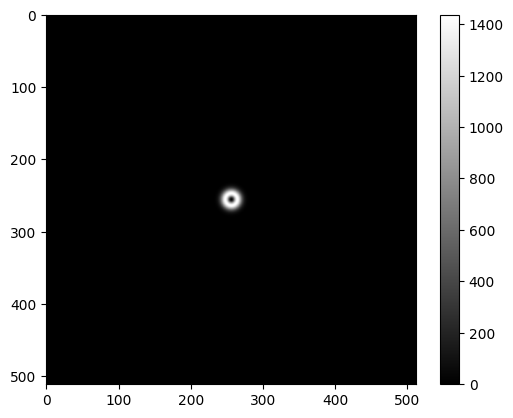

In [22]:
plt.imshow(results, cmap='gray')
plt.colorbar()
plt.show()